## Compare encoded jpg image and dicom ground-truth

In [1]:
import os
import json
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from random import randint
import cv2
import itertools
from tqdm import tqdm
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from skimage import exposure
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_DIR = "/media/daitran/Data/Kaggle/VinBigData"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
TRAIN_CSV_DIR = os.path.join(DATA_DIR, "train.csv")
SS_CSV_DIR = os.path.join(DATA_DIR, "sample_submission.csv")

PREPROCESSED_TRAINING_IMAGE_FOLDER = '/home/daitran/Desktop/research/kaggle/VinBigData/train/512_jpg/'

In [3]:
orin_df = pd.read_csv(TRAIN_CSV_DIR)
orin_df = orin_df.query('class_id != 14')

### Helper functions for converting bounding boxes to the right format for Mask RCNN

In [4]:
def get_mask(img_dimensions, x_min, y_min, x_max, y_max):
    img_height, img_width = img_dimensions
    img_mask = np.full((img_height,img_width),0)
    img_mask[y_min:y_max,x_min:x_max] = 255
    return img_mask.astype(np.float32)
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 255)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join([str(x) for x in run_lengths])

### Function convert DICOM data to np.array


In [5]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data

    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)

    return data


### Load data

#### Load img and encoded label data

In [6]:
training_df = pd.read_csv('/home/daitran/Desktop/git/chest_x_ray_abnormalities_detection/MaskRCNN_implementation/sample_df.csv', converters ={'EncodedPixels': eval, 'CategoryId': eval})

In [7]:
samples_df = training_df

## Implement Mask RCNN

In [8]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [9]:
NUM_CATS = 14
IMAGE_SIZE = 512

In [10]:
class DiagnosticConfig(Config):
    NAME = "Diagnostic"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class

    GPU_COUNT = 1
    IMAGES_PER_GPU = 2 #That is the maximum with the memory available on kernels

    BACKBONE = 'resnet50'

    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE
    IMAGE_RESIZE_MODE = 'none'

    POST_NMS_ROIS_TRAINING = 250
    POST_NMS_ROIS_INFERENCE = 150
    MAX_GROUNDTRUTH_INSTANCES = 5
    BACKBONE_STRIDES = [4, 8, 16, 32, 64]
    BACKBONESHAPE = (8, 16, 24, 32, 48)
    RPN_ANCHOR_SCALES = (8,16,24,32,48)
    ROI_POSITIVE_RATIO = 0.33
    DETECTION_MAX_INSTANCES = 300
    DETECTION_MIN_CONFIDENCE = 0.7
    # STEPS_PER_EPOCH should be the number of instances
    # divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    # however, due to the time limit, I set them so that this kernel can be run in 9 hours
    STEPS_PER_EPOCH = int(len(samples_df)*0.9/IMAGES_PER_GPU)
    VALIDATION_STEPS = len(samples_df)-int(len(samples_df)*0.9/IMAGES_PER_GPU)

config = DiagnosticConfig()
# config.display()

In [11]:
category_list = orin_df.class_name.unique()

In [12]:
class DiagnosticDataset(utils.Dataset):
    def __init__(self, df):
        super().__init__(self)

        # Add classes
        for i, name in enumerate(category_list):
            self.add_class("diagnostic", i+1, name)

        # Add images
        for i, row in df.iterrows():
            self.add_image("diagnostic",
                           image_id=row.name,
                           path= PREPROCESSED_TRAINING_IMAGE_FOLDER+str(row.image_id)+".jpg",
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'],
                           height=row['Height'], width=row['Width'],
                           img_org_id = row.image_id)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [category_list[int(x)] for x in info['labels']]

    def load_image(self, image_id):

        return cv2.imread(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]

        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)

            annotation = [int(x) for x in annotation.split(' ')]

            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)

            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
        return mask, np.array(labels)

In [13]:
training_percentage = 0.9

training_set_size = int(training_percentage*len(samples_df))
validation_set_size = int((1-training_percentage)*len(samples_df))

train_dataset = DiagnosticDataset(samples_df[:training_set_size])
train_dataset.prepare()

valid_dataset = DiagnosticDataset(samples_df[training_set_size:training_set_size+validation_set_size])
valid_dataset.prepare()

In [14]:
def plot_bbox(img_id , bbox_df = orin_df, normalize = True):

    img_ids = bbox_df['image_id'].values
    class_ids = bbox_df['class_id'].unique()

    label2color = {class_id:[randint(0,255) for i in range(3)] for class_id in class_ids}

    plt.figure(figsize=(20,8))
    sub_num =1

    img_id = img_id

    img_path = os.path.join(TRAIN_DIR, img_id + ".dicom")
    img = dicom2array(img_path)

    if normalize:
        # normalize
        img = exposure.equalize_adapthist(img/np.max(img))
        img = (img * 255).astype(np.uint8)

    # convert from single-channel grayscale to 3-channel RGB
    img = np.stack([img] * 3, axis=2)

    # add bounding boxes
    box_coordinates = bbox_df.loc[bbox_df['image_id'] == img_id, ['x_min', 'y_min', 'x_max', 'y_max']].values
    labels = bbox_df.loc[bbox_df['image_id'] == img_id, ['class_id']].values.squeeze()
    if not labels.shape:
        labels = np.expand_dims(labels, axis =0)

    for label_id, box in zip(labels, box_coordinates):
        color = label2color[label_id]
        img_bbox = cv2.rectangle(
            img,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color = color, thickness= 8
        )
        # add labels
        cv2.putText(img_bbox, str(label_id), (int(box[0]), int(box[1])), cv2.FONT_HERSHEY_SIMPLEX, 5, (36,255,12), 5)

    plt.subplot(1,3,sub_num)
    sub_num += 1
    plt.imshow(img_bbox, cmap = 'gray')
    plt.title('Finding contains in image')

    plt.show()

## Compare 

/home/daitran/Desktop/research/kaggle/VinBigData/train/512_jpg/0a072917005494298d153c01bbd8f689.jpg


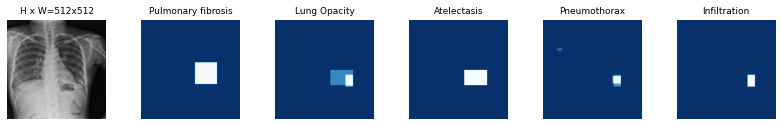

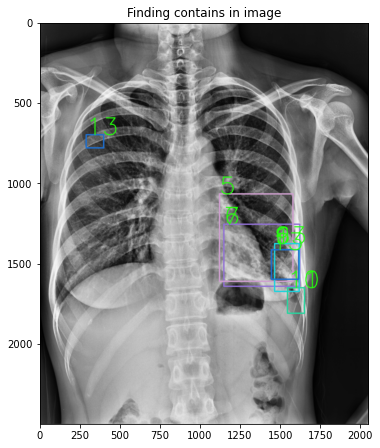

/home/daitran/Desktop/research/kaggle/VinBigData/train/512_jpg/ecf36a90601939ea964925fce1f0cc41.jpg


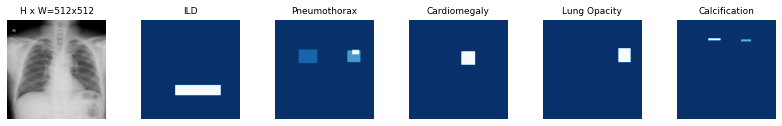

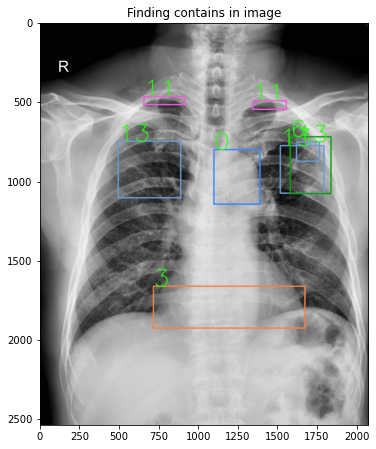

/home/daitran/Desktop/research/kaggle/VinBigData/train/512_jpg/2dae0b56a64f3708706e63711d970243.jpg


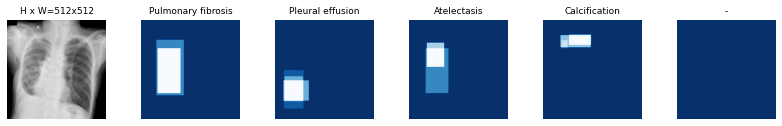

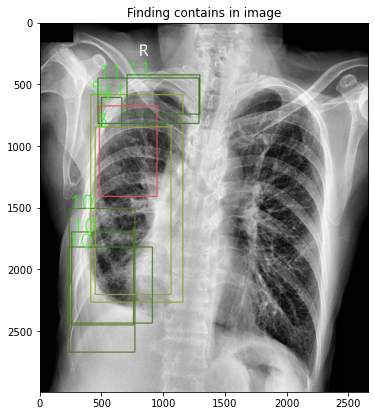

/home/daitran/Desktop/research/kaggle/VinBigData/train/512_jpg/72a8690f81423e91e710088e939dd664.jpg


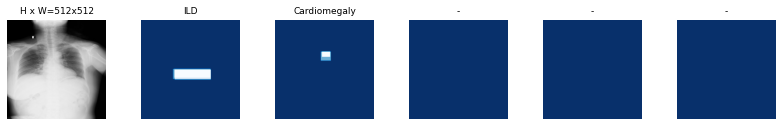

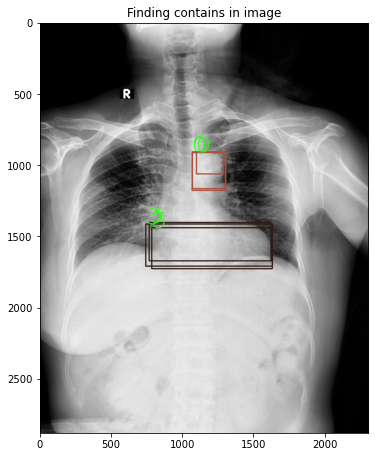

/home/daitran/Desktop/research/kaggle/VinBigData/train/512_jpg/ecf36a90601939ea964925fce1f0cc41.jpg


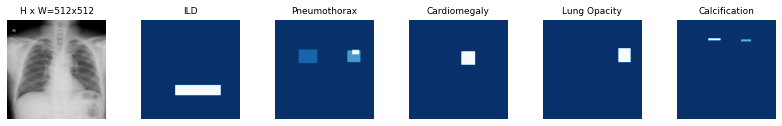

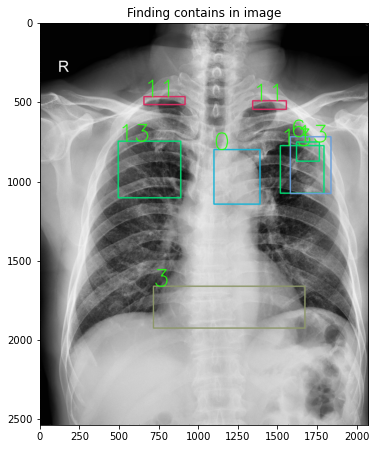

In [15]:
for i in range(0,5):
    image_jpg_id = random.choice(train_dataset.image_ids)
    print(train_dataset.image_info[image_jpg_id]['path'])
    
    image = train_dataset.load_image(image_jpg_id)
    mask, class_ids = train_dataset.load_mask(image_jpg_id)
    
    visualize.display_top_masks(image, mask, class_ids, train_dataset.class_names, limit=5)
    
#     print(train_dataset.image_info[image_id]['img_org_id'])
    plot_bbox(img_id = train_dataset.image_info[image_jpg_id]['img_org_id'])